In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter

try:
    import tensorboard
except ImportError:
    %pip install tensorboard
    import tensorboard

import subprocess
cmd = ["tensorboard", "--logdir=runs"]
tensorboard_process = subprocess.Popen(cmd)
print("TensorBoard is running. You can access it at http://localhost:6006")

import sklearn
from sklearn.datasets import load_digits

import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt

import netCDF4 as nc

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go

from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans
#import hdbscan

import cv2

TensorBoard is running. You can access it at http://localhost:6006


In [9]:
# Clustering parameters
DHR_variables = ['DHR1020', 'DHR443', 'DHR490', 'DHR565', 'DHR670', 'DHR865']

clustering_variables = DHR_variables + ['NDVI'] # Define the variables used for clustering
# clustering_variables = ['Ross_Li_BRDF_670_geometric_parameter', 'DHR670', 'SSA670', 'AAOD670', 'AODF1020', 'AExp', 'NDVI']
# clustering_variables = ['Water_Fraction_C', 'BrC_Fraction_C', 'Insoluble_Fraction_C', 'Iron_Fraction_C', 'NDVI']

num_clusters = 10   # Define the number of clusters

# Data parameters
selection = 'land' # Define the selection of the data (land, sea, both)

# Autoencoder parameters

input_dim = len(clustering_variables) # Define the input dimension of the autoencoder
n_latent = 2
n_hidden = input_dim

LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
print(f"Number of latent variables: {n_latent}")
print(f"Number of hidden neurons: {n_hidden}")
print(f"Variables used for clustering: {clustering_variables}")


Using cpu device
Number of latent variables: 2
Number of hidden neurons: 7
Variables used for clustering: ['DHR1020', 'DHR443', 'DHR490', 'DHR565', 'DHR670', 'DHR865', 'NDVI']


In [10]:
def normalize(data):
  return (data - data.mean()) / data.std()

def get_data(selection, clustering_variables, filename='data/GRASP_POLDER_L3_climatological_S1.1degree.nc', fill_value=-1000):
    """ Loads the data from the GRASP netCDF file and returns a pandas dataframe with the selected variables and the latitude and longitude """
    
    original_dataset = nc.Dataset(filename)
    img_shape = original_dataset.variables['DHR1020'][:].shape # we will use this to flatten the variables and get the shape back later

    # mask creation, to select the land or the sea or both
    if selection == 'sea':
        mask = (original_dataset.variables['LandPercentage'][:] == 100).filled(True)
    elif selection == 'land':
        mask = (original_dataset.variables['LandPercentage'][:] != 100).filled(True)
    else:
        mask = original_dataset.variables['DHR1020'][:].mask


    # flattening the variables / masking
    data = {}
    for var in original_dataset.variables:
        if original_dataset[var][:].shape == img_shape: # we only want the variables with the same shape as the image
            data[var] = original_dataset[var][:].flatten()
            data[var][mask.flatten()] = fill_value

    # creating the dataframe
    df = pd.DataFrame(data)
    #del data, original_dataset # free some memory

    # we explicitly set the fill_value to nan
    df = df.replace(fill_value, np.nan)
    df = df[clustering_variables + ['Latitude', 'Longitude']]
    df.dropna(inplace=True)
    data = df[clustering_variables].values
    data = normalize(data)
    return data, df,mask,img_shape

In [11]:
# Load the data
file_path = 'data/GRASP_POLDER_L3_climatological_S1.1degree.nc'
data, df,mask,img_shape = get_data('land', clustering_variables, file_path, fill_value=-1000)
dataset = torch.utils.data.DataLoader(data, batch_size = BATCH_SIZE, shuffle=True)

In [12]:
# we compare to a PCA
from sklearn.decomposition import PCA

n_components = 7

pca = PCA(n_components=n_components)

# Create a color map for the different numbers
cmap = plt.get_cmap('tab10')

# use the same data as before
pca_data = pca.fit_transform(data)
# plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap=cmap, s=10, alpha=0.5)
# plt.show()

# Inverse transform
pca_data = pca.inverse_transform(pca_data)

MSE = F.mse_loss(torch.Tensor(pca_data), torch.Tensor(data))
R2 = 1 - MSE/data.var()
print(f'MSE : {MSE.mean():.4f} ; R2 : {R2.mean():.4f}')

pca_data = pca.fit_transform(data)

# make an hexbin plot
# plt.hexbin(pca_data[:, 0], pca_data[:, 1], cmap='viridis', gridsize=50)
# plt.colorbar()
# plt.show()

# hist2D = np.array(np.histogram2d(pca_data[:, 0], pca_data[:, 1], bins=50))
# plt.imshow(hist2D[0], cmap='viridis')
# plt.colorbar()
# plt.show()

MSE : 0.0000 ; R2 : 1.0000


[8.1502953e+01 1.6000648e+01 2.1328518e+00 2.0081568e-01 1.0595743e-01
 3.3046149e-02 2.3737041e-02]


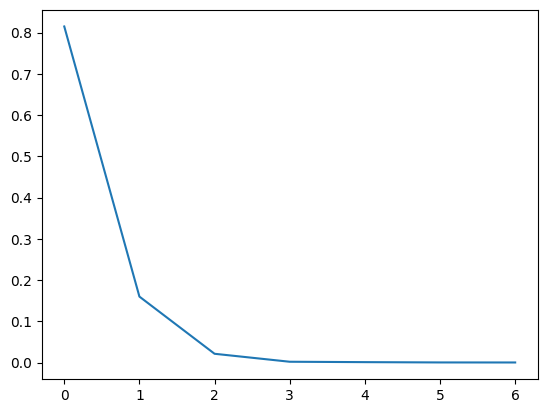

In [13]:
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_*100)

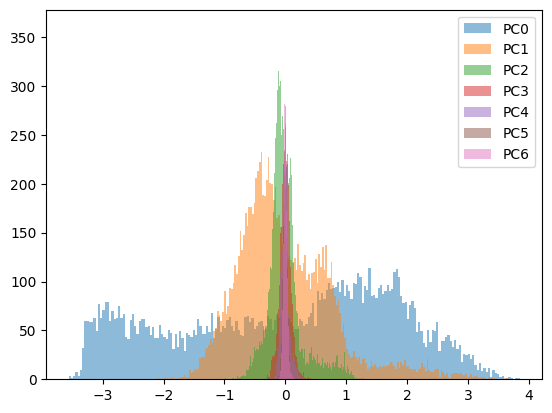

In [14]:
for i in range(n_components):
    plt.hist(pca_data[:,i], label=f'PC{i}', bins=200, alpha=0.5)
plt.legend()
plt.show()

In [15]:
def plot_with_density(x,y, log=False):
    # Step 1: Create a 2D histogram for density estimation
    hist, x_edges, y_edges = np.histogram2d(x,y, bins=(100, 100))
    # Step 2: Assign density values to points
    x_idx = np.digitize(x, x_edges) - 1  # Get the bin index for each x
    y_idx = np.digitize(y, y_edges) - 1  # Get the bin index for each y
    # Handle points that may fall on the right edge of the last bin
    x_idx[x_idx == hist.shape[0]] -= 1
    y_idx[y_idx == hist.shape[1]] -= 1
    # Use the histogram to assign a density value to each point
    if log:
        point_density = np.log(hist[x_idx, y_idx])
    else:
        point_density = hist[x_idx, y_idx]

    idx = point_density.argsort()
    x, y, point_density = x[idx], y[idx], point_density[idx]

    # Step 3: Color points by density in the scatter plot
    cmap = plt.get_cmap('viridis')  # Choose a color map
    plt.scatter(x,y, c=point_density, s=10, cmap=cmap, alpha=0.5)
    plt.colorbar(label='Density')
    plt.show()

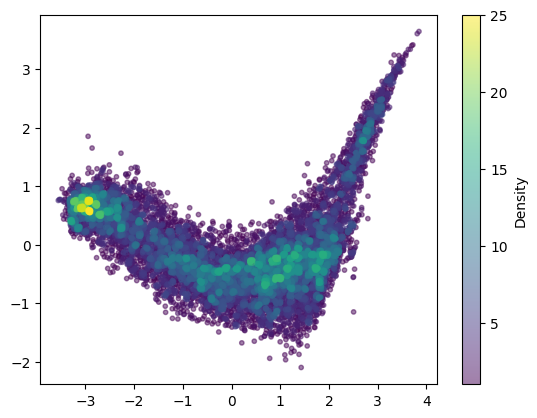

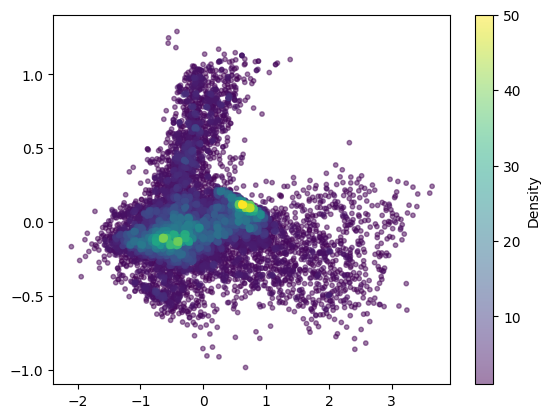

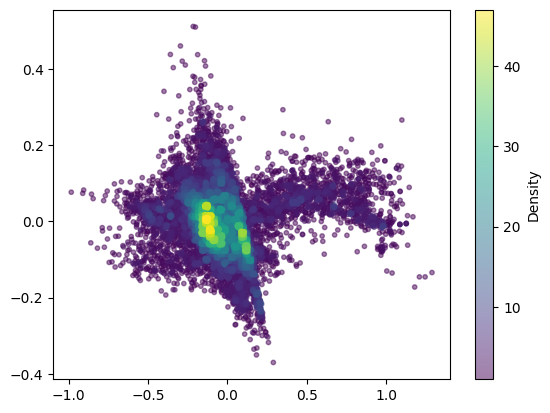

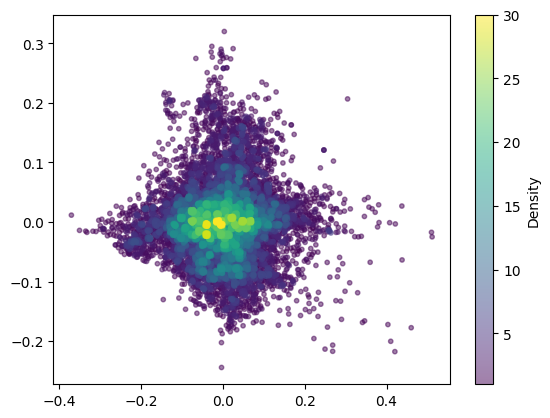

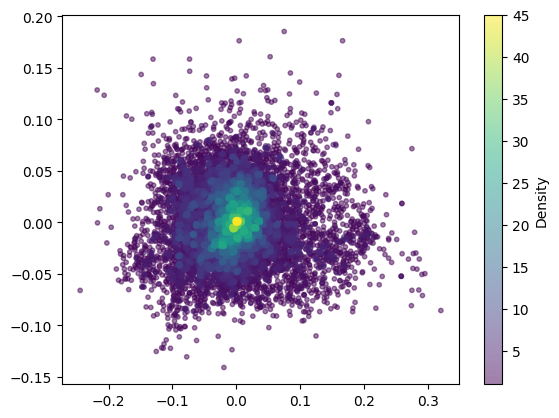

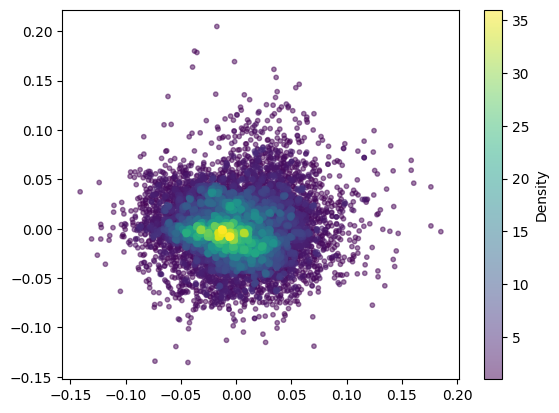

In [25]:
for i in range(6):
    plot_with_density(pca_data[:, i], pca_data[:, i+1], log=False)

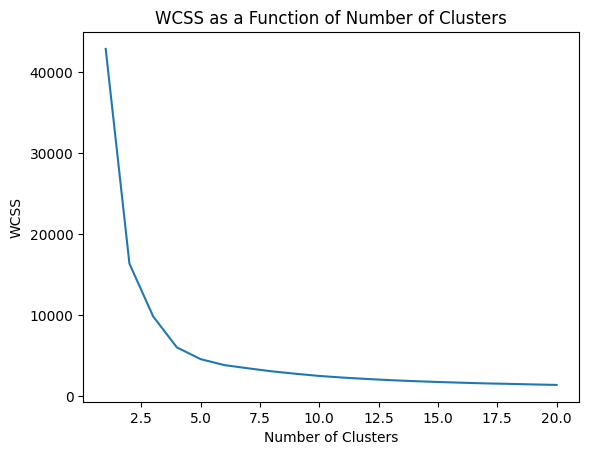

In [27]:
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('WCSS as a Function of Number of Clusters')
plt.show()

In [28]:
from utils import plot_variable,show_results

n_clusters=5
kmeans_pca = KMeans(n_clusters=n_clusters)
kmeans_pca.fit(pca_data)
labels_pca = kmeans_pca.labels_
t = df.copy()[clustering_variables]
t.dropna(inplace=True)
t['clusters'] = kmeans_pca.labels_
t['Latitude'] = df['Latitude']
t['Longitude'] = df['Longitude']

plot_variable(t, 'clusters', colormap = cm.plasma)

c:\Users\vince\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [21]:
kmeans_pca.labels_

array([13, 13, 13, ..., 12, 12, 12])

In [22]:
for i in range(n_clusters):
    print((labels_pca == i).sum())

238
461
476
499
495
728
357
757
648
964
504
669
428
572
684
515
361
384
421
709


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


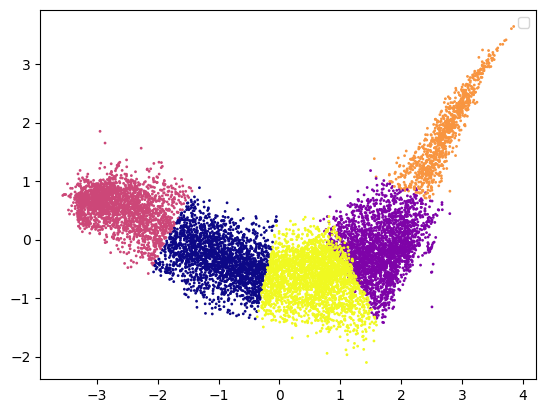

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


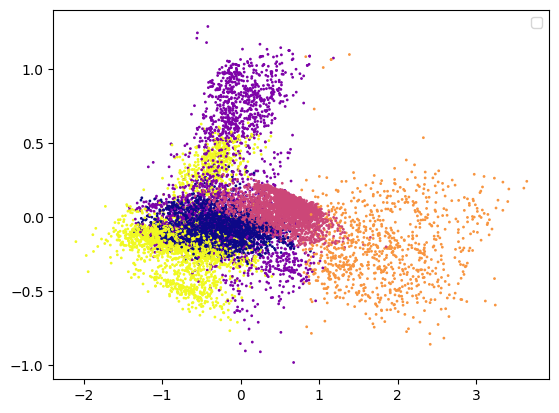

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


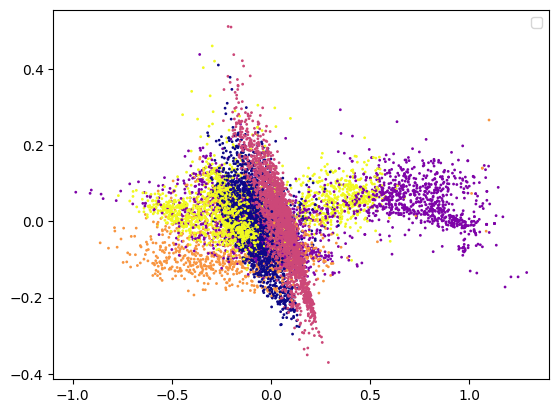

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


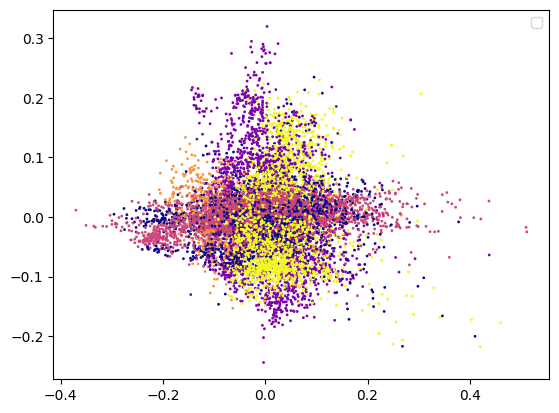

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


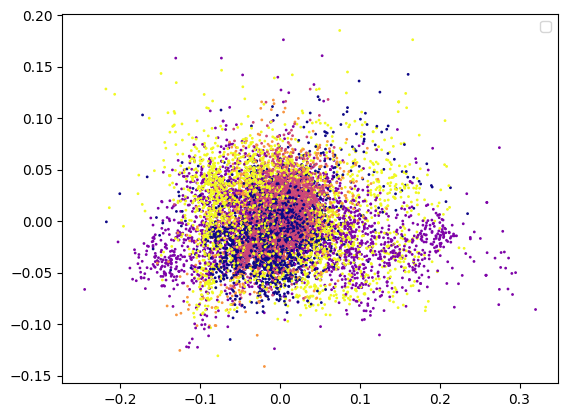

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


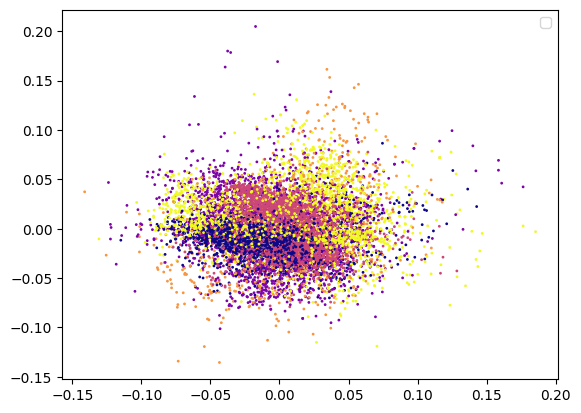

In [29]:
for i in range(n_components-1):
    plt.scatter(pca_data[:, i], pca_data[:, i+1], c=labels_pca, cmap=cm.plasma, s=1, alpha=1)
    plt.legend()
    plt.show()

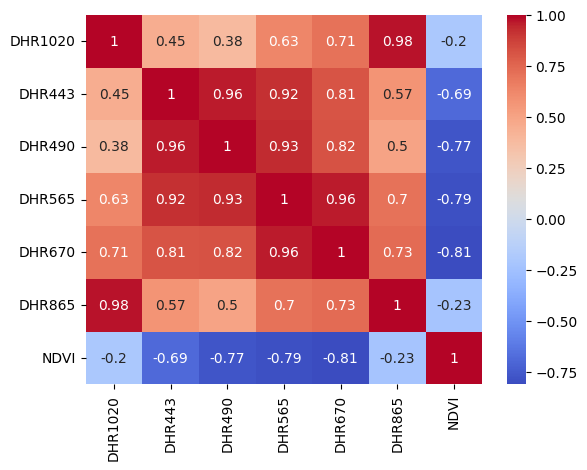

In [24]:
import seaborn as sns
correlation_matrix = pd.DataFrame(data, columns=['DHR1020', 'DHR443', 'DHR490', 'DHR565', 'DHR670', 'DHR865', 'NDVI']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


drop DHR865
NDVI ~ 670-565
include other variables